In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import pymc3 as pm
from pymc3 import Model, Normal, Slice
from pymc3 import sample
from pymc3 import traceplot
from pymc3.distributions import Interpolated
from theano import as_op
import theano.tensor as tt
import numpy as np
from scipy import stats

plt.style.use('seaborn-darkgrid')
print('Running on PyMC3 v{}'.format(pm.__version__))

Running on PyMC3 v3.9.3


In [2]:
# Initialize random number generator
np.random.seed(93457)

In [3]:
# True parameter values
alpha_true = 5
beta0_true = 7
beta1_true = 13

# Size of dataset
size = 100

In [4]:
# Predictor variable
X1 = np.random.randn(size)
X2 = np.random.randn(size) * 0.2

# Simulate outcome variable
Y = alpha_true + beta0_true * X1 + beta1_true * X2 + np.random.randn(size)

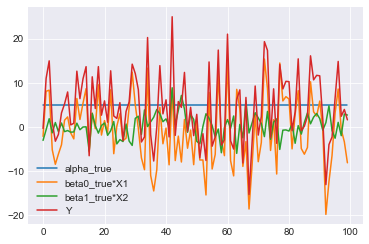

In [5]:
plt.figure()
plt.plot(range(len(Y)), [alpha_true]*len(Y))
plt.plot(range(len(Y)), X1*beta0_true)
plt.plot(range(len(Y)), X2*beta1_true)
plt.plot(range(len(Y)), Y)
plt.legend(["alpha_true", "beta0_true*X1", "beta1_true*X2", "Y"])
plt.show()

## Model Specification

our initial beliefs about the params are informative (sigma =1) and a bit off the true values

In [6]:
basic_model = Model()

with basic_model:
    #priors for unknown model params
    alpha = Normal('alpha', mu=0, sigma=1)
    beta0 = Normal('beta0', mu=12, sigma=1)
    beta1 = Normal('beta1', mu=18, sigma=1)
    
    # Expected value of outcome
    mu = alpha + beta0*X1 + beta1*X2
    
    # likelihood (sampling distribution) of observation
    Y_obs = Normal('Y_obs', mu=mu, sigma=1, observed = Y)
    
    trace = sample(1000)
    
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta1, beta0, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.


C:\Users\rwyde\Miniconda3\lib\site-packages\arviz\data\io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'alpha'}>],
       [<AxesSubplot:title={'center':'beta0'}>,
        <AxesSubplot:title={'center':'beta0'}>],
       [<AxesSubplot:title={'center':'beta1'}>,
        <AxesSubplot:title={'center':'beta1'}>]], dtype=object)

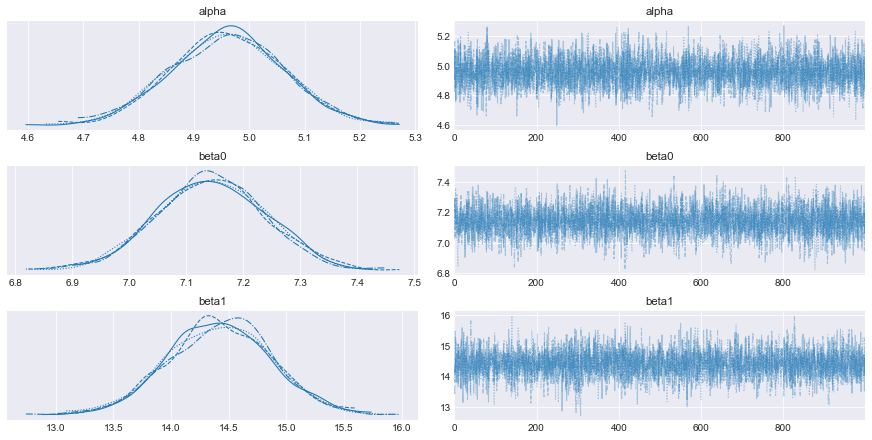

In [7]:
traceplot(trace)

In [13]:
def from_posterior(param, samples):
    smin = np.min(samples)
    smax = np.max(samples)
    width = smax - smin
    x = np.linspace(smin, smax, 100)
    y = stats.gaussian_kde(samples)(x)
    
    
    #what was never sampled should have a small probability but not 0
    # so we'll extend the domain and use linear approximation of density on it
    
    x = np.concatenate([[x[0] - 3*width], x, [x[-1] + 3*width]])
    y = np.concatenate([[0], y, [0]])
    return Interpolated(param, x, y)


now we just need to generate more data and build our Bayesian model so that the prior distributions for the current iteration are the posterior distributions from the previous iteration. It is still possible to continue usint NUTS sampling method because Interpolated class implements calculation of gradients taht are necessary for Hamiltonian Monte Carlo samplers. 

In [14]:
traces = [trace]

In [15]:
for _ in range(10):
    
    #generate more data
    
    X1 = np.random.randn(size)
    X2 = np.random.randn(size)
    Y = alpha_true + beta0_true * X1 + beta1_true *X2 + np.random.randn(size)
    
    model = Model()
    
    with model:
        
        #priors are posteriors from previous iteration
        alpha = from_posterior('alpha', trace['alpha'])
        beta0 = from_posterior('beta0', trace['beta0'])
        beta1 = from_posterior('beta1', trace['beta1'])
        
        mu = alpha + beta0 * X1 + beta1 * X2
        
        Y_obs = Normal('Y_obs', mu=mu, sigma=1, observed=Y)
        
        trace = sample(1000)
        traces.append(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta1, beta0, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta1, beta0, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta1, beta0, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta1, beta0, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta1, beta0, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta1, beta0, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta1, beta0, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta1, beta0, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta1, beta0, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta1, beta0, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.


In [ ]:
print("Posterior distributions after {} iterations".format(str(len(traces))))
cmap = mpl.cm.autumn

for param in ['alpha', 'beta0', 'beta1']:
    plt.figure(figsize=(8,2))
    for update_i, trace in enumerate(traces):
        samples = trace[param]
        smin = np.min(samples)
        smax = np.max(samples)
        x = np.linspace(smin, smax, 100)
        y = stats.gaussian_kde(samples)(x)
        plt.plot(x, y, color=cmap(1 - update_i / len(traces)))
        
    plt.axvline({'alpha': alpha_true, 'beta0': beta0_true, 'beta1': beta1_true}[param], c='k')